# コード2-3：線形常微分方程式の数値計算の実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

線形常微分方程式を数値計算する例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

In [1]:
## 必要があればインストール
# !pip3 install matplotlib numpy scipy

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

## 線形常微分方程式の数値計算

式（2.8）

$$
\begin{align}
\frac{d I \left( t \right)}{dt} &= \beta T(0) V(t) - \delta I(t) \\
\frac{d V \left( t \right)}{dt} &= p I(t) - c V(t)
\end{align}
$$

について、
- $\beta = 0.00000006, \delta = 0.5, p = 100, c = 20, T(0) = 1000, I(0) = 10, V(0) = 20$
- $\beta = 0.000006, \delta = 0.5, p = 1000, c = 20, T(0) = 1000, I(0) = 10, V(0) = 20$
の時の$I(t), V(t)$を数値計算によって求める。

SciPyパッケージに含まれるintegrateモジュールのodeint関数を使う。  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

In [39]:
## 計算する時刻の設定
Tmin = 0.0
Tmax = 10.0
step_size = 0.0001

## パラメータの設定
## beta, delta, p, c, T(0), I(0), V(0)
pars1 = np.array([0.00000006, 0.5, 100, 20, 10000, 10, 20])
pars2 = np.array([0.0000006, 0.5, 1000, 20, 10000, 10, 20])

In [40]:
## 傾き（微分）の定義
def ode_derives(var, t, beta, delta, p, c, T0):
  
  ## var[0]: I(t), var[1]: V(t)
  dIdt = beta * T0 * var[1] - delta * var[0]
  dVdt = p * var[0] - c * var[1]

  return [dIdt, dVdt]

## パラメータを受け取ってodeint関数に渡す関数
def ODEs(parms):
  beta = parms[0]
  delta = parms[1]
  p = parms[2]
  c = parms[3]
  T0 = parms[4]

  ## 計算のタイムステップ
  t_list = np.arange(Tmin, Tmax + step_size, step_size)
  ## 初期値 I(0), V(0)
  var_init = [parms[5], parms[6]]
  ## 微分方程式の計算
  var_list = odeint(ode_derives, var_init, t_list, args = (beta, delta, p, c, T0))

  return np.vstack([t_list, var_list.T])

In [41]:
out1 = ODEs(pars1)
out2 = ODEs(pars2)

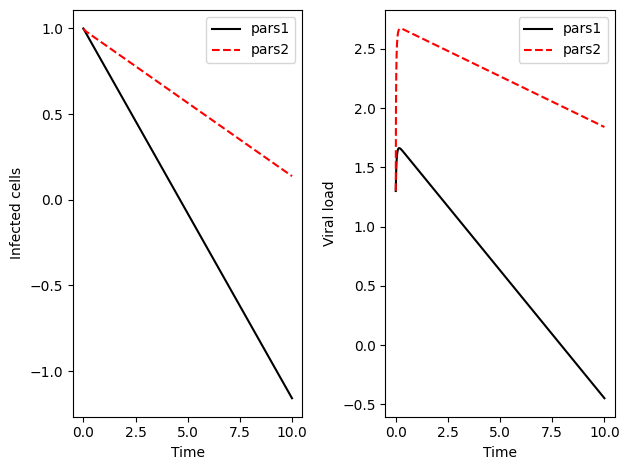

In [42]:
## プロットの準備
fig = plt.figure()

## I(t)のプロット
ax1 = fig.add_subplot(1, 2, 1) ## 1行2列のプロットの１番目
ax1.plot(out1[0], np.log10(out1[1]), color = "black", label = "pars1") ## pars1でのI(t)の数値解のプロット
ax1.plot(out2[0], np.log10(out2[1]), color = "red", linestyle = "dashed", label = "pars2") ## pars2でのI(t)の数値解のプロット
ax1.set_xlabel("Time") ## x軸のラベル
ax1.set_ylabel("Infected cells") ## y軸のラベル
ax1.legend() ## レジェンドの追加

## V(t)のプロット
ax2 = fig.add_subplot(1, 2, 2) ## 1行2列のプロットの2番目
ax2.plot(out1[0], np.log10(out1[2]), color = "black", label = "pars1") ## pars1でのV(t)の数値解のプロット
ax2.plot(out2[0], np.log10(out2[2]), color = "red", linestyle = "dashed", label = "pars2") ## pars2でのV(t)の数値解のプロット
ax2.set_xlabel("Time") ## x軸のラベル
ax2.set_ylabel("Viral load") ## y軸のラベル
ax2.legend() ## レジェンドの追加

fig.tight_layout()
fig.show()

## 解析解を用いた確認

式（2.8）の解析解は式（2.10）

$$
\begin{align}
I(t) &= \frac{\beta T(0) V(0) - \left(\delta + \theta _2 \right) I(0)}
              {\theta_1- \theta_2}
          \left(e^{ \theta_1 t }-e^{\theta_2 t} \right)
          + I(0) e^{\theta_2 t} \\
V(t) &= \frac{pI(0) - \left( c + \theta_2 \right) I(0)}
              {\theta_1- \theta_2}
          \left(e^{ \theta_1 t }-e^{\theta_2 t} \right)
          + V(0) e^{\theta_2 t} 
\end{align}
$$

であり、ここで

$$
\begin{align}
\theta_1 &= \frac{-(\delta + c) + \sqrt{(\delta - c)^2 + 4 \beta pT(0) }}{2} \\
\theta_2 &= \frac{-(\delta + c) - \sqrt{(\delta - c)^2 + 4 \beta pT(0) }}{2}
\end{align}
$$

である。

数値解と重ねてプロットしてみる。


In [7]:
## パラメータを受け取ってtheta_1の値を返す関数
def theta1(parms):
  beta = parms[0]
  delta = parms[1]
  p = parms[2]
  c = parms[3]
  T0 = parms[4]

  return (- (delta + c) + np.sqrt((delta - c)**2 + 4*beta*p*T0)) / 2

## パラメータを受け取ってtheta_2の値を返す関数
def theta2(parms):
  beta = parms[0]
  delta = parms[1]
  p = parms[2]
  c = parms[3]
  T0 = parms[4]

  return (- (delta + c) - np.sqrt((delta - c)**2 + 4*beta*p*T0)) / 2

## パラメータを受け取って解析解を返す関数
def ODEs_analytical(parms):
  ## パラメータ
  beta = parms[0]
  delta = parms[1]
  p = parms[2]
  c = parms[3]
  T0 = parms[4]
  I0 = parms[5]
  V0 = parms[6]

  ## 時間のリスト
  t_list = np.arange(Tmin, Tmax + step_size, step_size)

  ## パラメータの値から計算されるtheta_1
  theta1_c = theta1(parms)
  ## パラメータの値から計算されるtheta_2
  theta2_c = theta2(parms)

  ## I(t)の解析解の値
  I_list = ((beta * T0 * V0 - (delta + theta2_c) * I0) / (theta1_c - theta2_c)) * (np.exp(theta1_c * t_list) - np.exp(theta2_c * t_list)) + I0 * np.exp(theta2_c * t_list)
  ## V(t)の解析解の値
  V_list = ((p * I0 - (c + theta2_c) * I0) / (theta1_c - theta2_c)) * (np.exp(theta1_c * t_list) - np.exp(theta2_c * t_list)) + V0 * np.exp(theta2_c * t_list)

  return np.array([t_list, I_list, V_list])

In [8]:
## 解析解
out_analytical = ODEs_analytical(pars1)

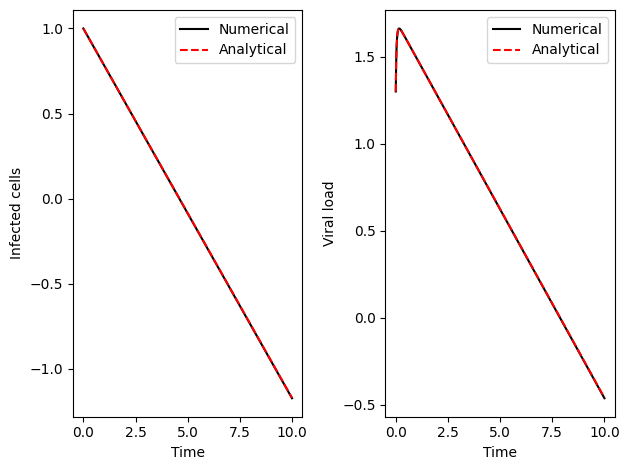

In [9]:
## プロットの準備
fig = plt.figure()

## I(t)のプロット
ax1 = fig.add_subplot(1, 2, 1) ## 1行2列のプロットの１番目 
ax1.plot(out1[0], np.log10(out1[1]), color = "black", label = "Numerical") ## I(t)の数値解のプロット
ax1.plot(out_analytical[0], np.log10(out_analytical[1]), color = "red", linestyle = "dashed", label = "Analytical") ## I(t)の解析解のプロット
ax1.set_xlabel("Time") ## x軸のラベルの設定
ax1.set_ylabel("Infected cells") ## y軸のラベルの設定
ax1.legend() ## レジェンドの追加

## V(t)のプロット
ax2 = fig.add_subplot(1, 2, 2) ## 1行2列のプロットの2番目
ax2.plot(out1[0], np.log10(out1[2]), color = "black", label = "Numerical") ## V(t)の数値解のプロット
ax2.plot(out_analytical[0], np.log10(out_analytical[2]), color = "red", linestyle = "dashed", label = "Analytical") ## V(t)の解析解のプロット
ax2.set_xlabel("Time") ## x軸のラベルの設定
ax2.set_ylabel("Viral load") ## y軸のラベルの設定
ax2.legend() ## レジェンドの追加

fig.tight_layout()
fig.show()